In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
import numpy as np
import argparse
import os
from unicodedata import decimal
from tqdm import tqdm

# hard-code random seeds for deterministic outcomes
np.random.seed(42)
torch.manual_seed(42)
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

import matplotlib.pyplot as plt

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200,10)

    def forward(self, x):
        x = x.view((-1, 28*28))
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        return x

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(5, 5))
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(5, 5))
        self.bn2 = nn.BatchNorm2d(32)
        self.conv2_drop = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(128, 100)
        self.fc2 = nn.Linear(100, 10)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3))
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=(3, 3))
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=(1, 1))
        self.bn6 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.conv2_drop(F.max_pool2d(self.bn2(x), 2))
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2_drop(x)
        x = F.relu(self.conv5(x))
        x = self.bn5(x)
        x = F.relu(self.conv6(x))
        x = self.bn6(x)
        size = x.size()[1] * x.size()[2] * x.size()[3]
        # print(size)
        x = x.view(-1, size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [16]:
# loading the dataset
# note that this time we do not perfrom the normalization operation, see next cell
test_dataset = datasets.MNIST(
    'mnist_data/',
    train=False,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor()]
    )
)

In [17]:
class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# we load the body of the pre-trained neural net...
model = torch.load('/content/model.net', map_location='cpu')

# ... and add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), model)

# and here we also create a version of the model that outputs the class probabilities
model_to_prob = nn.Sequential(model, nn.Softmax())

# we put the neural net into evaluation mode (this disables features like dropout)
model.eval()
model_to_prob.eval()

<ipython-input-17-5f23a2a3348e>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/model.net', map_location='cpu')
/usr/local/lib/python3.10/dist-

Sequential(
  (0): Sequential(
    (0): Normalize()
    (1): ConvNet(
      (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2_drop): Dropout2d(p=0.2, inplace=False)
      (fc1): Linear(in_features=128, out_features=100, bias=True)
      (fc2): Linear(in_features=100, out_features=10, bias=True)
      (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (bn5): BatchNorm2d(128, eps=1e-05, momentum=

In [18]:
def show(original, adv, model_to_prob):
    p0 = model_to_prob(original).detach().numpy()
    p1 = model_to_prob(adv).detach().numpy()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(original.detach().numpy().reshape(28, 28), cmap='gray')
    axarr[0].set_title("Original, class: " + str(p0.argmax()))
    axarr[1].imshow(adv.detach().numpy().reshape(28, 28), cmap='gray')
    axarr[1].set_title("Adversarial, class: " + str(p1.argmax()))
    print("Class\t\tOrig\tAdv")
    for i in range(10):
        print("Class {}:\t{:.2f}\t{:.2f}".format(i, float(p0[:, i]), float(p1[:, i])))
    plt.show()

In [19]:
def fgsm_(model, x, target, eps, targeted=True, clip_min=None, clip_max=None):
    """Internal process for all FGSM and PGD attacks."""
    # create a copy of the input, remove all previous associations to the compute graph...
    input_ = x.clone().detach_()
    # ... and make sure we are differentiating toward that variable
    input_.requires_grad_()

    # run the model and obtain the loss
    logits = model(input_)
    target = torch.LongTensor([target])
    model.zero_grad()
    loss = nn.CrossEntropyLoss()(logits, target)
    loss.backward()

    #perfrom either targeted or untargeted attack
    if targeted:
        out = input_ - eps * input_.grad.sign()
    else:
        out = input_ + eps * input_.grad.sign()

    #if desired clip the ouput back to the image domain
    if (clip_min is not None) or (clip_max is not None):
        out.clamp_(min=clip_min, max=clip_max)
    return out

In [20]:
# x: input image
# label: current label of x
# k: number of FGSM iterations
# eps: size of l-infinity ball
# eps_step: step size of FGSM iterations
def pgd(model, x, label, k, eps, eps_step, targeted, clip_min, clip_max):
    x_min = x.clone().detach_() - eps
    x_max = x.clone().detach_() + eps
    x_adv = x.clone().detach_()
    for i in range(k):
      x_adv = fgsm_(model, x_adv, label, eps_step, targeted, clip_min, clip_max)
      x_adv = torch.min(x_max, torch.max(x_min, x_adv))
    return x_adv


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
<ipython-input-18-9a195dd56465>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Class {}:\t{:.2f}\t{:.2f}".format(i, float(p0[:, i]), float(p1[:, i])))


Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	0.00	0.00
Class 2:	0.00	0.00
Class 3:	0.00	1.00
Class 4:	0.00	0.00
Class 5:	0.00	0.00
Class 6:	0.00	0.00
Class 7:	1.00	0.00
Class 8:	0.00	0.00
Class 9:	0.00	0.00


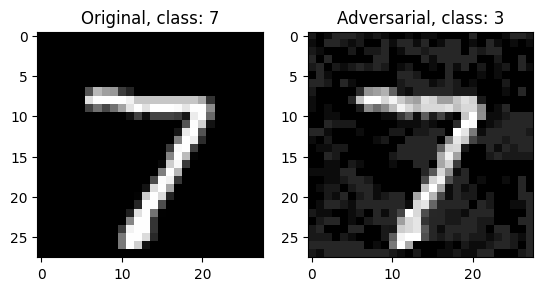

In [21]:
# try out our attacks
original = torch.unsqueeze(test_dataset[0][0], dim=0)

adv = pgd(model, original, label=7, k=10, eps=0.15, eps_step=0.05, targeted=False, clip_min=0, clip_max=1.0)

show(original, adv, model_to_prob)

[TRADES algorithm
](https://arxiv.org/pdf/1901.08573)


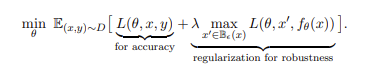

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = x.view((-1, 28 * 28))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307) / 0.3081

def fgsm_batch(model, x_batch, target, eps, targeted=False, clip_min=None, clip_max=None):
    """Internal process for all FGSM and PGD attacks."""
    # create a copy of the input, remove all previous associations to the compute graph...
    input_ = x_batch.clone().detach_()
    # ... and make sure we are differentiating toward that variable
    input_.requires_grad_()
    # run the model and obtain the loss
    logits = model(input_)
    target = torch.LongTensor(target)
    model.zero_grad()
    loss = nn.CrossEntropyLoss()(logits, target)
    loss.backward()
    #perfrom either targeted or untargeted attack
    if targeted:
        out = input_ - eps * input_.grad.sign()
    else:
        out = input_ + eps * input_.grad.sign()

    #if desired clip the ouput back to the image domain
    if (clip_min is not None) or (clip_max is not None):
        out.clamp_(min=clip_min, max=clip_max)
    return out



def pgd_batch(model, x_batch, target, k, eps, eps_step):
    # implement pgd for batch
    # calculate min
    x_min = x_batch.clone().detach_() - eps
    #calculate max
    x_max = x_batch.clone().detach_() + eps
    x_adv = x_batch.clone().detach_()
    #perform fgsm attack k times
    for i in range(k):
      x_adv = fgsm_batch(model, x_adv, target, eps_step, False, clip_min=0, clip_max=255)
      x_adv = torch.min(x_max, torch.max(x_min, x_adv))
    return x_adv

batch_size = 512
learning_rate = 0.01
defense = 'TRADES'
num_epochs = 10
eps = 0.1
k = 7
trades_fact = 1.0
eps_step = 2.5 * (eps/k)


# Datasets
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

# Data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), Net())
model = model.to(device)


opt = optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(opt, 15)
ce_loss = torch.nn.CrossEntropyLoss()


for epoch in range(1, num_epochs + 1):
    # Training
    for batch_idx, (x_batch, y_batch) in enumerate(tqdm(train_loader)):

        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        if defense == 'PGD':
            x_batch_adv = pgd_batch(model, x_batch, y_batch, k, eps, eps_step)
            model.train()
            out_adv = model(x_batch_adv)
            loss = ce_loss(out_adv, y_batch)
        elif defense == 'TRADES':
            x_batch_adv = pgd_batch(model, x_batch, y_batch, k, eps, eps_step)
            model.train()
            out_adv = model(x_batch_adv)
            out_nat = model(x_batch)
            loss = ce_loss(out_nat, y_batch) + trades_fact*ce_loss(out_adv, y_batch)

        elif defense == 'none':
            # standard training
            model.train()  # switch to training mode
            out_nat = model(x_batch)
            loss = ce_loss(out_nat, y_batch)

        opt.zero_grad()
        loss.backward()
        opt.step()

    # Testing
    model.eval()
    tot_test, tot_acc, tot_adv_acc = 0.0, 0.0, 0.0
    for batch_idx, (x_batch, y_batch) in enumerate(tqdm(test_loader)):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        out = model(x_batch)
        pred = torch.max(out, dim=1)[1]
        acc = pred.eq(y_batch).sum().item()

        x_batch_adv = pgd_batch(model, x_batch, y_batch, k, eps, eps_step)
        out_adv = model(x_batch_adv)
        pred_adv = torch.max(out_adv, dim=1)[1]
        acc_adv = pred_adv.eq(y_batch).sum().item()

        # Accumulate accuracies
        tot_acc += acc
        tot_adv_acc += acc_adv
        tot_test += x_batch.size()[0]

    scheduler.step()

    print('Epoch %d: Accuracy %.5lf, Adv Accuracy %.5lf' % (epoch, tot_acc / tot_test, tot_adv_acc / tot_test))

# optionally save the model
#os.makedirs("models", exist_ok=True)
#torch.save(model.state_dict(), f"models/Net_{args.num_epochs}_{args.defense}")


100%|██████████| 20/20 [00:03<00:00,  6.23it/s]


Epoch 1: Accuracy 0.96090, Adv Accuracy 0.76520


100%|██████████| 20/20 [00:03<00:00,  5.80it/s]


Epoch 2: Accuracy 0.96560, Adv Accuracy 0.78230


100%|██████████| 20/20 [00:04<00:00,  4.97it/s]


Epoch 3: Accuracy 0.97210, Adv Accuracy 0.81310


100%|██████████| 20/20 [00:04<00:00,  4.73it/s]


Epoch 4: Accuracy 0.97040, Adv Accuracy 0.81400


100%|██████████| 20/20 [00:04<00:00,  4.48it/s]


Epoch 5: Accuracy 0.97560, Adv Accuracy 0.82190


100%|██████████| 20/20 [00:04<00:00,  4.44it/s]


Epoch 6: Accuracy 0.97470, Adv Accuracy 0.82290


100%|██████████| 20/20 [00:03<00:00,  5.14it/s]


Epoch 7: Accuracy 0.97570, Adv Accuracy 0.81160


100%|██████████| 20/20 [00:03<00:00,  5.31it/s]


Epoch 8: Accuracy 0.97660, Adv Accuracy 0.83470


100%|██████████| 20/20 [00:03<00:00,  5.36it/s]


Epoch 9: Accuracy 0.97440, Adv Accuracy 0.81290


100%|██████████| 20/20 [00:03<00:00,  6.25it/s]

Epoch 10: Accuracy 0.97850, Adv Accuracy 0.82870
